In [1]:
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, device="cpu", max_len = 100):
        super().__init__()
        self.pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).type(torch.float32)
        tmp = torch.arange(0,d_model,2)
        den = 1/torch.pow(torch.ones(int(d_model/2))*max_len,2*tmp/d_model)
        den = den.unsqueeze(0)
        self.pe[:,0::2] = torch.sin(torch.matmul(pos,den))
        self.pe[:,1::2] = torch.cos(torch.matmul(pos,den))
        self.pe = self.pe.to(device)

    def forward(self, x):
        # scale = self.pe.shape[1]**0.5
        return x + self.pe[:x.shape[1],:]

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device):
        super(TransformerModel, self).__init__()
        # embed_dim = head_dim * num_heads?

        self.output_size = output_size

        self.input_fc = nn.Linear(input_size, d_model)
        self.output_fc = nn.Linear(input_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, device)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            batch_first=True,
            dropout=dropout,
            device=device
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            dim_feedforward=4 * d_model,
            batch_first=True,
            device=device
        )
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=encoder_num_layers)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=decoder_num_layers)
        self.fc = nn.Linear(output_size * d_model, output_size)
        self.fc1 = nn.Linear(seq_len * d_model, d_model)
        self.fc2 = nn.Linear(d_model, output_size)

    def forward(self, x):
        # print(x.size())  # (256, 24, 7)
        y = x[:, -self.output_size:, :]
        # print(y.size())  # (256, 4, 7)
        x = self.input_fc(x)  # (256, 24, 128)
        x = self.pos_emb(x)   # (256, 24, 128)
        x = self.encoder(x)
        # 不经过解码器
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        out = self.fc2(x)

        # y = self.output_fc(y)   # (256, 4, 128)
        # out = self.decoder(y, x)  # (256, 4, 128)
        # out = out.flatten(start_dim=1)  # (256, 4 * 128)
        # out = self.fc(out)  # (256, 4)

        return out

In [21]:
import pandas as pd
import sys

df = pd.read_csv('./Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

df_use = df[0:2]
# df_use = df_use[:300]
# df_use.index = range(len(df_use))

df_use[['Destination Port',]]

KeyError: "None of [Index(['Destination Port'], dtype='object')] are in the [columns]"

In [21]:
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import numpy as np
import torch

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def nn_seq_us(batch_size, step):
    print('data processing...')
    dataset = df_use
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.85)]
    test = dataset[int(len(dataset) * 0.85):len(dataset)]
    m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])

    def process(data, batch_size, shuffle):
        load = data[data.columns[:]]
        # print(load.values)
        load = load.values
        data = data.values.tolist()
        load = (load - n) / (m - n)

        seq = []
        for i in range(len(data) - step):
            train_seq = []
            train_label = []
            for j in range(i, i + step):
                x = [load[j]]
                train_seq.append(x)
            # for c in range(2, 8):
            #     train_seq.append(data[i + step][c])
            train_label.append(load[i + step])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        # print(seq[-1])
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    data_train = process(train, batch_size, True)
    data_validate = process(val, batch_size, True)
    data_test = process(test, batch_size, False)

    return data_train, data_validate, data_test, m, n

In [22]:
from torch.optim.lr_scheduler import StepLR as StepLR
from tqdm import tqdm
from copy import deepcopy

def get_val_loss(model, data_validate, loss_function, device):
    model.eval()
    val_loss = []
    for (seq, label) in data_validate:
        seq = seq.to(device)
        seq.resize_(batch_size, step, input_size)

        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        val_loss.append(loss.item())

    return sum(val_loss)/len(val_loss)# MSE


def transformer_train(data_train, data_validate, path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size=1, hidden_size=10, num_layers=2, output_size = 1, batch_size = 5, optimizer = 'adam', max_epochs = 20, lr = 0.01, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    weight_decay = 0.00005
    step_size = 5
    gamma = 0.1


    model = TransformerModel(input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device).to(device)

    loss_function = nn.MSELoss().to(device)
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 10

    train_loss = 10086
    min_train_loss = 10

    for epoch in range(max_epochs):
        train_loss_list = []
        for (seq, label) in data_train:
            optimizer.zero_grad()

            seq = seq.to(device)
            seq.resize_(batch_size, step, input_size)

            label = label.to(device)
            y_pred = model(seq)
            train_loss = loss_function(y_pred, label[:,0].unsqueeze(1))
            train_loss_list.append(train_loss.item())
            train_loss.backward()
            optimizer.step()

        scheduler.step()

        # validation_data
        val_loss = get_val_loss(model, data_validate, loss_function, device)
        # print(val_loss, min_val_loss)
        # if epoch > min_epochs and val_loss < min_val_loss:
        #     min_val_loss = val_loss
        #     best_model = deepcopy(model)
        #     print(type(model))
        #
        # if epoch % 10 == 0:
        #     print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))

        # train_data
        if epoch > min_epochs and val_loss < min_val_loss * 1.1:
            if  train_loss < min_train_loss :
                min_train_loss = train_loss
                min_val_loss = val_loss
                best_model = deepcopy(model)
                print(type(model))

        if epoch % 10 == 0:
            print('epoch {:03d} train_loss {:.8f}'.format(epoch, np.mean(train_loss_list)))


        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

In [53]:
from itertools import chain
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def get_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# def lstm_test(data_test, path, m, n, input_size = 1,  hidden_size = 10, num_layers = 2, output_size = 1, batch_size = 5, device = torch.device('cpu')):
def transformer_test(data_test, path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device):
    pred = []
    y = []
    print('loading models...')

    model = TransformerModel(input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device).to(device)

    loss_function = nn.MSELoss().to(device)

    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in data_test:
        target = list(chain.from_iterable(target[:, 0].unsqueeze(1).data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        seq.resize_(batch_size, step, input_size)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n

    return pred, get_mse(y, pred), get_mape(y, pred)

def save_img(df_use, pred, seq_len, savepath, save_title):


    # 计算出pred的开始结束下标
    dataset = df_use
    test = dataset[int(len(dataset) * 0.85):len(dataset)]
    start = test.index[0]
    end = start + pred.__len__()

    plt.plot(dataset.index, dataset, c='green', marker='*', ms=1, alpha=0.75, label='true')
    pred_x = [i for i in range(start, end)]
    plt.plot(pred_x, pred, c='red', marker='o', ms=1, alpha=0.75, label='pred')

    plt.grid(axis='y')
    plt.legend()
    plt.title(save_title)
    plt.savefig(savepath, dpi=600)
    plt.show()

In [26]:
input_size = 1
hidden_size=8
num_layers=1
output_size = 1
batch_size = 1
optimizer = 'adam'
max_epochs = 25
lr = 0.002
# lr = 0.03

step = 24    # 每step_size个epoch调整一次学习率

seq_len = 24  #
d_model = 64

nhead = 8
dropout = 0.1

encoder_num_layers = 2
decoder_num_layers = 1


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_path = './transformer_model/best_model_transformer.model'

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)



data processing...
epoch 000 train_loss 0.10772662
epoch 010 train_loss 0.00067286
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00053977


data processing...
epoch 000 train_loss 0.07194760
epoch 010 train_loss 0.00017146
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00015642
loading models...
predicting...


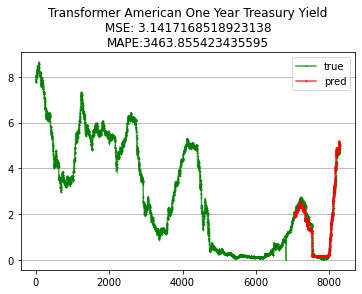

data processing...
epoch 000 train_loss 0.06992611
epoch 010 train_loss 0.00020567
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00017683
loading models...
predicting...


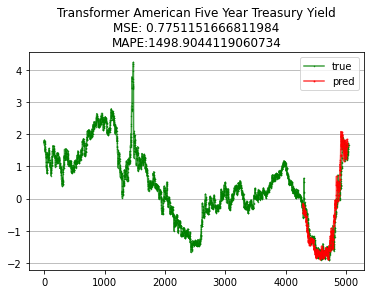

In [27]:
df = pd.read_csv('./american_1.csv')
df_use = df[['Yield']]
df_use = df_use[:]
df_use.index = range(len(df_use))

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_us_1.png', f'Transformer American One Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )





df = pd.read_csv('./american_5.csv')
df_use = df[['Yield']]
df_use = df_use[:]
df_use.index = range(len(df_use))

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_us_5.png', f'Transformer American Five Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )


data processing...
epoch 000 train_loss 0.12905504
epoch 010 train_loss 0.00027408
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00025606
loading models...
predicting...


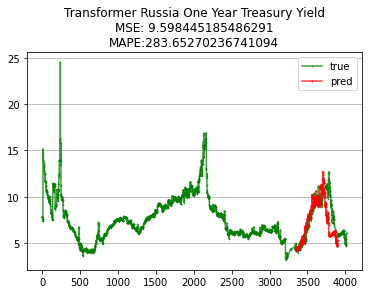

data processing...
epoch 000 train_loss 0.12040638
epoch 010 train_loss 0.00033546
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00027944
loading models...
predicting...


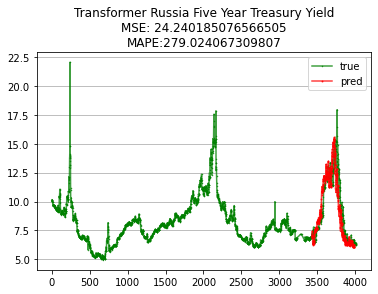

In [54]:
df = pd.read_csv('./russia.csv')
df_use = df[['Yield_1']]
df_use = df_use[:]
df_use.index = range(len(df_use))
df_use = df_use.dropna(0, 'any')


data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_russia_1.png', f'Transformer Russia One Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )




df = pd.read_csv('./russia.csv')
df_use = df[['Yield_5']]
df_use = df_use[:]
df_use.index = range(len(df_use))
df_use = df_use.dropna(0, 'any')


data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_russia_5.png', f'Transformer Russia Five Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )

data processing...
epoch 000 train_loss 0.08762661
epoch 010 train_loss 0.00037752
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00036292
<class '__main__.TransformerModel'>
loading models...
predicting...


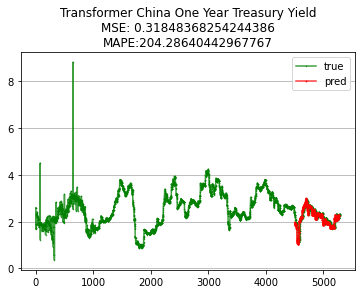

data processing...
epoch 000 train_loss 0.07944846
epoch 010 train_loss 0.00037646
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00035363
loading models...
predicting...


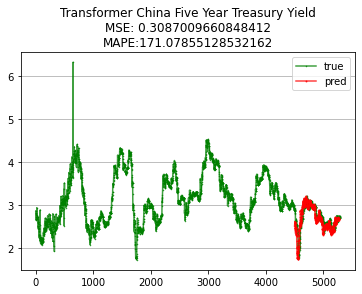

In [55]:
df = pd.read_csv('./china.csv')
df_use = df[['Yield_1']]
df_use = df_use[:]
df_use.index = range(len(df_use))
df_use = df_use.dropna(0, 'any')

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_china_1.png', f'Transformer China One Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )




df = pd.read_csv('./china.csv')
df_use = df[['Yield_5']]
df_use = df_use[:]
df_use.index = range(len(df_use))
df_use = df_use.dropna(0, 'any')

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_china_5.png', f'Transformer China Five Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )

data processing...
epoch 000 train_loss 0.09480213
epoch 010 train_loss 0.00096812
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00080116
loading models...
predicting...


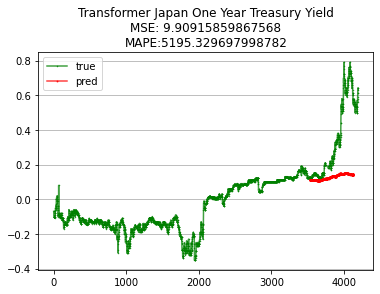

data processing...
epoch 000 train_loss 0.08677637
epoch 010 train_loss 0.00041115
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
<class '__main__.TransformerModel'>
epoch 020 train_loss 0.00037289
loading models...
predicting...


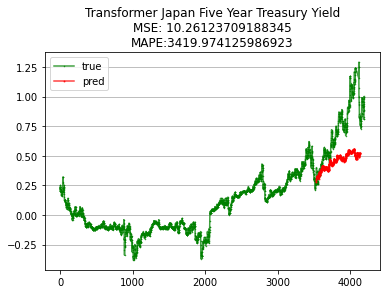

In [56]:
df = pd.read_csv('./japan.csv')
df_use = df[['Yield_1']]
df_use = df_use[:]
df_use.index = range(len(df_use))
df_use = df_use.dropna(0, 'any')

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_japan_1.png', f'Transformer Japan One Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )




df = pd.read_csv('./japan.csv')
df_use = df[['Yield_5']]
df_use = df_use[:]
df_use.index = range(len(df_use))
df_use = df_use.dropna(0, 'any')

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

transformer_train(data_train, data_validate, model_path, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, input_size, hidden_size, num_layers, output_size, batch_size, optimizer, max_epochs, lr, device)


pred, mse, mape = transformer_test(data_test, model_path, m, n, input_size, output_size, seq_len, d_model, nhead, dropout, encoder_num_layers, decoder_num_layers, device)

save_img(df_use, pred, seq_len, './transformer_japan_5.png', f'Transformer Japan Five Year Treasury Yield\nMSE: {mse*100}\nMAPE:{mape*100}' )